In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    LSTM,
    Bidirectional,
    Dropout,
    Flatten,
    Dense,
    Input,
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

from utils import load_dataset, train, auc, plot_roc
from einops import rearrange

In [2]:
NUM_OUTPUTS = 31

model = Sequential(
    [
        Input(shape=(1000, 4)),
        Conv1D(320, kernel_size=8, activation="relu"),
        MaxPooling1D(pool_size=4, strides=4),
        Dropout(0.2),
        Conv1D(480, kernel_size=8, activation="relu"),
        MaxPooling1D(pool_size=8, strides=8),
        Dropout(0.2),
        Flatten(data_format="channels_first"),
        Dense(3*512, activation="relu"),
        Dense(NUM_OUTPUTS, activation="softmax"),
    ],
    name="deepsea_full",
)

model.summary()

Model: "deepsea_full"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 993, 320)          10560     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 248, 320)          0         
_________________________________________________________________
dropout (Dropout)            (None, 248, 320)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 241, 480)          1229280   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 480)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 480)           0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)            

In [3]:
es = EarlyStopping(monitor="val_loss", patience=10)

epochs = 250
validation_freq = 1

X_train, y_train, X_test, y_test = load_dataset(
    file="FOX_3000",
    out_dir="/home/victor/Documents/datasets",
    labels="binlabels"
)

X_train = rearrange(X_train, "w h c -> w c h")
X_test = rearrange(X_test, "w h c -> w c h")

Epoch 1/250
10000/10000 - 541s - loss: 0.1575 - acc: 0.2252 - val_loss: 0.1453 - val_acc: 0.2896
Epoch 2/250
10000/10000 - 531s - loss: 0.1451 - acc: 0.2833 - val_loss: 0.1413 - val_acc: 0.2935
Epoch 3/250
10000/10000 - 531s - loss: 0.1432 - acc: 0.2882 - val_loss: 0.1404 - val_acc: 0.2951
Epoch 4/250
10000/10000 - 528s - loss: 0.1422 - acc: 0.2903 - val_loss: 0.1402 - val_acc: 0.2943
Epoch 5/250
10000/10000 - 525s - loss: 0.1414 - acc: 0.2924 - val_loss: 0.1403 - val_acc: 0.2939
Epoch 6/250
10000/10000 - 545s - loss: 0.1408 - acc: 0.2946 - val_loss: 0.1402 - val_acc: 0.2995
Epoch 7/250
10000/10000 - 540s - loss: 0.1401 - acc: 0.2961 - val_loss: 0.1404 - val_acc: 0.2975
Epoch 8/250
10000/10000 - 517s - loss: 0.1396 - acc: 0.2984 - val_loss: 0.1404 - val_acc: 0.2925
Epoch 9/250
10000/10000 - 504s - loss: 0.1391 - acc: 0.2998 - val_loss: 0.1411 - val_acc: 0.2949
Epoch 10/250
10000/10000 - 509s - loss: 0.1386 - acc: 0.3021 - val_loss: 0.1409 - val_acc: 0.2885
Epoch 11/250
10000/10000 - 50

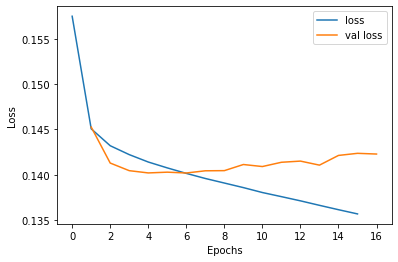

Training time: 139.94 minutes


ValueError: multilabel-indicator format is not supported

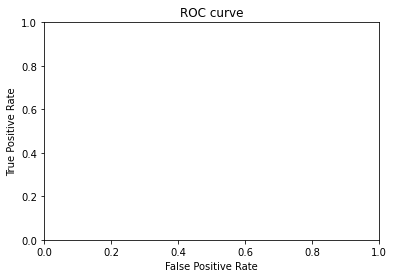

In [4]:
model.compile(optimizer=Adam(lr=1e-3), loss="binary_crossentropy", metrics=["acc"])

model = train(
    dataset=(X_train, y_train, X_test, y_test),
    model=model,
    epochs=epochs,
    verbose=2,
    validation_freq=validation_freq,
    callbacks=[es],
    batch_size=100,
)

y_pred = model.predict(X_test)
plot_roc(y_test, y_pred)
print(auc(y_test, y_pred))

model.save(f"../model_saves/evals/{model.name}-{n}000.h5")